In [13]:
from autodistill_grounding_dino import GroundingDINO
from autodistill.detection import CaptionOntology
import cv2
import supervision as sv
from rich import print
import duckdb
from core_pro.ultilities import make_sync_folder

In [7]:
path = make_sync_folder('Item_Matching_Test')
file = path / 'result_match_image/Beauty__Skincare__Acne Treatment.parquet'

query = f"""
select * 
from read_parquet('{file}')
-- where q_item_id = 24282169285
"""
df = duckdb.sql(query).pl()
df.head()

shape: (5, 25)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ q_item_id ┆ q_item_na ┆ q_shop_id ┆ q_shop_na ┆ … ┆ db_item_n ┆ db_file_p ┆ db_exists ┆ score_im │
│ ---       ┆ me        ┆ ---       ┆ me        ┆   ┆ ame_clean ┆ ath       ┆ ---       ┆ age_embe │
│ i64       ┆ ---       ┆ i64       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ list[bool ┆ d        │
│           ┆ str       ┆           ┆ str       ┆   ┆ list[str] ┆ list[str] ┆ ]         ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ list[f32 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ ]        │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 222855212 ┆ Kem dưỡng ┆ 143999625 ┆ Mỹ phẩm A ┆ … ┆ ["kem     ┆ ["/home/k ┆ [true,    ┆ [1.0,    │
│ 62        ┆ da giảm   ┆           ┆ cclear    ┆   ┆ dưỡng da  ┆ evin/Down ┆ true, …   ┆ 0.532997 │
│           ┆ mụn giúp  ┆           ┆           ┆   ┆ giảm mụn  ┆ loads/Dat ┆ true]     ┆ , …      │
│           ┆ làm…      ┆           ┆           ┆   ┆ giúp l…   ┆ a/I…      ┆           ┆ 0.4991]  │
│ 256595435 ┆ Gel Ngừa  ┆ 18363975  ┆ Dr Thêm   ┆ … ┆ ["gel     ┆ ["/home/k ┆ [true,    ┆ [1.0,    │
│ 83        ┆ Mụn và    ┆           ┆ Official  ┆   ┆ ngừa mụn  ┆ evin/Down ┆ true, …   ┆ 0.826263 │
│           ┆ Giảm Thâm ┆           ┆ Store     ┆   ┆ và giảm   ┆ loads/Dat ┆ true]     ┆ , … 0.71 │
│           ┆ Acne…     ┆           ┆           ┆   ┆ thâm ac…  ┆ a/I…      ┆           ┆ 8445]    │
│ 266592488 ┆ Cao mụn   ┆ 130168196 ┆ HD        ┆ … ┆ ["cao mụn ┆ ["/home/k ┆ [true,    ┆ [1.0,    │
│ 46        ┆ sâm đỏ    ┆ 5         ┆ Beauty29  ┆   ┆ sâm đỏ    ┆ evin/Down ┆ true, …   ┆ 0.732748 │
│           ┆ hộp full  ┆           ┆           ┆   ┆ hộp full  ┆ loads/Dat ┆ true]     ┆ , … 0.68 │
│           ┆ 15g (c…   ┆           ┆           ┆   ┆ 15g …     ┆ a/I…      ┆           ┆ 8303]    │
│ 197430415 ┆ [SHOPEE   ┆ 60733229  ┆ Lenimosho ┆ … ┆ ["hàng    ┆ ["/home/k ┆ [true,    ┆ [1.0,    │
│ 0         ┆ Video     ┆           ┆ p_Y Tế    ┆   ┆ chính hãn ┆ evin/Down ┆ true, …   ┆ 0.785719 │
│           ┆ giảm 50%  ┆           ┆ Việt      ┆   ┆ g]miếng   ┆ loads/Dat ┆ true]     ┆ , … 0.60 │
│           ┆ đơn 100…  ┆           ┆           ┆   ┆ dán mụ…   ┆ a/I…      ┆           ┆ 1456]    │
│ 299539433 ┆ Gel tẩy   ┆ 718126614 ┆ Yummi.Cos ┆ … ┆ ["gel tẩy ┆ ["/home/k ┆ [true,    ┆ [1.0,    │
│ 07        ┆ nốt ruồi, ┆           ┆ metic     ┆   ┆ nốt ruồi, ┆ evin/Down ┆ true, …   ┆ 0.843775 │
│           ┆ mụn cóc,  ┆           ┆           ┆   ┆ mụn cóc,  ┆ loads/Dat ┆ true]     ┆ , … 0.59 │
│           ┆ mụn…      ┆           ┆           ┆   ┆ m…        ┆ a/I…      ┆           ┆ 6877]    │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [52]:
idx = 1
run_q = df[['q_item_name', 'q_category', 'q_file_path']].to_dicts()
run_db = df[['db_item_name', 'db_category', 'db_file_path', 'score_image_embed']].to_dicts()
print(run_q[idx])
print(run_db[idx])

{
    'q_item_name': 'Gel Ngừa Mụn và Giảm Thâm Acnes (Sealing Jell / CLEAR CREAM/ Scar Care / Dán Mụn)- Dr Thêm',
    'q_category': 'Beauty__Skincare__Acne Treatment',
    'q_file_path': '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_FMCG/img_/00000/0000001847.jpg'
}

{
    'db_item_name': [
        'Gel Ngừa Mụn và Giảm Thâm Acnes (Sealing Jell / CLEAR CREAM/ Scar Care / Dán Mụn)- Dr Thêm',
        'Kem Dưỡng Giảm Mụn Chuyên Sâu Acnes Blemish Clear Cream 10gr',
        'Kem giảm mụn chuyên sâu Acnes Blemish Clear Cream 10g',
        'Kem Dưỡng Acnes Làm Giảm Mụn Chuyên Sâu 10g | Hasaki | Sản phẩm chính hãng',
        'Gel Sạch Mụn & Sạch Khuẩn Sealing Jell Acnes 18Gr',
        'Actidem Derma Gel 18gr,40gr / Actidem Derma Extra Gel 18gr Gel giảm mụn, dưỡng ẩm da',
        'Kem chấm mụn chuyên sâu Acnes Blemish Clear Cream 10g',
        'Derma Forte 15g - Gamma, Bản Thường / Advanced, Gel Giúp Giảm Mụn Trứng Cá, Ngừa Thâm, Mờ Sẹo, Da Dầu Mụn 
- Dr Thêm',
        'Gel Giảm Mụn Mờ Thâm Mụn Actidem Derma Gel Ngăn Ngừa Mụn Tái Phát (18, 40g)',
        '[CHÍNH HÃNG] Miếng dán mụn Acnes BHA 2% che, ngăn, giảm mụn, ngừa thâm, sẹo, băng dính mỏng chắc, trong 
suốt, chống nước'
    ],
    'db_category': [
        'Beauty__Skincare__Acne Treatment',
        'Beauty__Skincare__Acne Treatment',
        'Beauty__Skincare__Acne Treatment',
        'Beauty__Skincare__Acne Treatment',
        'Beauty__Skincare__Acne Treatment',
        'Beauty__Skincare__Acne Treatment',
        'Beauty__Skincare__Acne Treatment',
        'Beauty__Skincare__Acne Treatment',
        'Beauty__Skincare__Acne Treatment',
        'Beauty__Skincare__Acne Treatment'
    ],
    'db_file_path': [
        '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_FMCG/img_/00000/0000001847.jpg',
        '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_FMCG/img_/00001/0000120876.jpg',
        '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_FMCG/img_/00001/0000103004.jpg',
        '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_FMCG/img_/00000/0000024601.jpg',
        '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_FMCG/img_/00001/0000108931.jpg',
        '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_FMCG/img_/00001/0000100112.jpg',
        '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_FMCG/img_/00000/0000032396.jpg',
        '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_FMCG/img_/00001/0000120150.jpg',
        '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_FMCG/img_/00001/0000144722.jpg',
        '/home/kevin/Downloads/Data/Item_Matching_Test/download_img_FMCG/img_/00001/0000108221.jpg'
    ],
    'score_image_embed': [
        1.0,
        0.8262630105018616,
        0.813834011554718,
        0.7735469937324524,
        0.7514579892158508,
        0.7340350151062012,
        0.7335780262947083,
        0.726364016532898,
        0.7247949838638306,
        0.7184450030326843
    ]
}

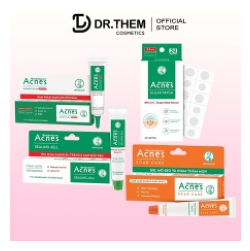

In [53]:
sv.plot_image(cv2.imread(run_q[idx]['q_file_path']), size=(3, 3))

In [54]:
from collections import defaultdict


box_lst, crop_lst = [], defaultdict(list)
box_annot = sv.BoxAnnotator()
for cat, img_path in zip(run_db[idx]['db_category'], run_db[idx]['db_file_path']):
    item_ = cat.split('__')[-1]
    # item = 'Charms'
    base_model = GroundingDINO(ontology=CaptionOntology({f"{item_}": f"{item_}"}))
    result = base_model.predict(img_path)

    # plot
    image = cv2.imread(img_path)
    img_annot = box_annot.annotate(scene=image.copy(), detections=result)
    box_lst.append(img_annot)

    # crop
    for i, v in enumerate(result.xyxy):
        crop_img = sv.crop_image(image=image.copy(), xyxy=v)
        crop_lst[img_path].append(crop_img)
    # break
del base_model

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


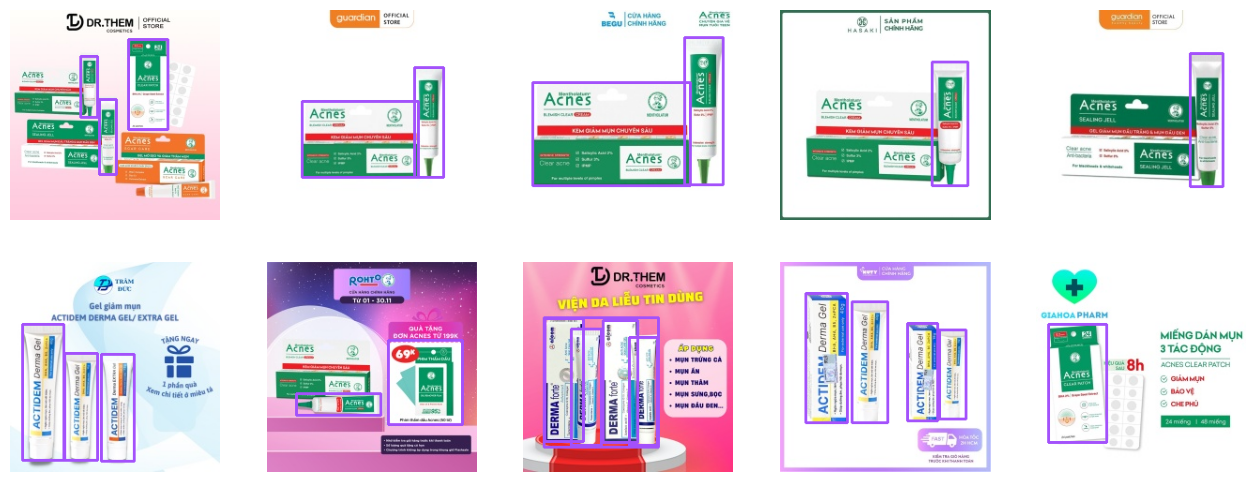

In [55]:
sv.plot_images_grid(box_lst, grid_size=(2, 5), size=(16, 6))

In [56]:
crop_lst[list(crop_lst.keys())[0]]

[array([[[249, 250, 254],
         [248, 254, 243],
         [208, 225, 181],
         ...,
         [222, 235, 211],
         [247, 253, 248],
         [247, 250, 255]],
 
        [[248, 249, 253],
         [247, 255, 235],
         [116, 142,  72],
         ...,
         [169, 188, 145],
         [246, 254, 243],
         [246, 250, 251]],
 
        [[247, 248, 252],
         [246, 255, 230],
         [108, 143,  53],
         ...,
         [166, 189, 134],
         [245, 255, 235],
         [248, 252, 247]],
 
        ...,
 
        [[242, 236, 253],
         [255, 252, 255],
         [255, 254, 255],
         ...,
         [254, 250, 255],
         [246, 240, 255],
         [238, 230, 253]],
 
        [[241, 235, 252],
         [254, 250, 255],
         [252, 251, 255],
         ...,
         [255, 251, 255],
         [250, 245, 255],
         [234, 227, 248]],
 
        [[235, 229, 248],
         [244, 238, 255],
         [238, 235, 251],
         ...,
         [243, 237, 254],
  

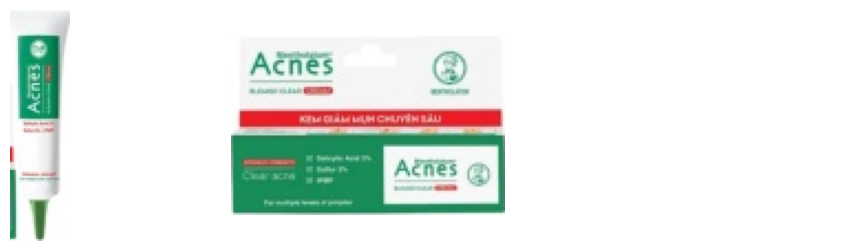

In [57]:
sv.plot_images_grid(crop_lst[list(crop_lst.keys())[1]], grid_size=(1, 3), size=(12, 3))

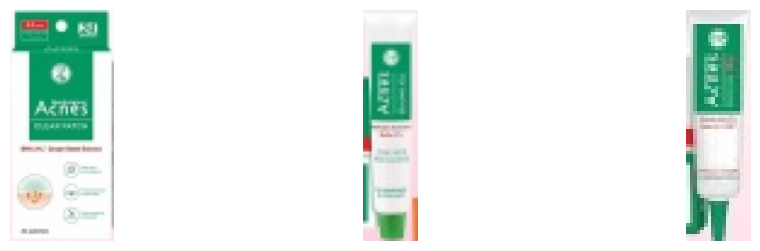

In [58]:
sv.plot_images_grid(crop_lst[list(crop_lst.keys())[0]], grid_size=(1, 3), size=(12, 3))